In [51]:
import xarray as xr
import numpy as np
import pandas as pd
import numpy.ma as ma

In [52]:
#from gsw package

def enthalpy_SSO_0_p(p):
    db2Pascal = 1e4
    SSO = 35.16504
    v01 = 9.998420897506056e+2
    v05 = -6.698001071123802
    v08 = -3.988822378968490e-2
    v12 = -2.233269627352527e-2
    v15 = -1.806789763745328e-4
    v17 = -3.087032500374211e-7
    v20 = 1.550932729220080e-10
    v21 = 1.0
    v26 = -7.521448093615448e-3
    v31 = -3.303308871386421e-5
    v36 = 5.419326551148740e-6
    v37 = -2.742185394906099e-5
    v41 = -1.105097577149576e-7
    v43 = -1.119011592875110e-10
    v47 = -1.200507748551599e-15
    a0 = v21 + SSO * (v26 + v36 * SSO + v31 * np.sqrt(SSO))
    a1 = v37 + v41 * SSO
    a2 = v43
    a3 = v47
    b0 = v01 + SSO * (v05 + v08 * np.sqrt(SSO))
    b1 = 0.5 * (v12 + v15 * SSO)
    b2 = v17 + v20 * SSO
    b1sq = b1 ** 2
    sqrt_disc = np.sqrt(b1sq - b0 * b2)
    N = a0 + (2 * a3 * b0 * b1 / b2 - a2 * b0) / b2
    M = a1 + (4 * a3 * b1sq / b2 - a3 * b0 - 2 * a2 * b1) / b2
    A = b1 - sqrt_disc
    B = b1 + sqrt_disc
    part = (N * b2 - M * b1) / (b2 * (B - A))
    return (db2Pascal * (p * (a2 - 2 * a3 * b1 / b2 + 0.5 * a3 * p) / b2 +
            (M / (2 * b2)) * np.log(1 + p * (2 * b1 + b2 * p) / b0) + part *
            np.log(1 + (b2 * p * (B - A)) / (A * (B + b2 * p)))))


def z_from_p(p, lat, geo_strf_dyn_height=0):
    DEG2RAD = np.pi / 180.0
    gamma = 2.26e-7
    X = np.sin(lat * DEG2RAD)
    sin2 = X ** 2
    B = 9.780327 * (1.0 + (5.2792e-3 + (2.32e-5 * sin2)) * sin2)
    A = -0.5 * gamma * B
    C = enthalpy_SSO_0_p(p) - geo_strf_dyn_height

    return -2 * C / (B + np.sqrt(B ** 2 - 4 * A * C))


In [53]:
tempOV=np.zeros((24,103))
latOV=np.zeros(103)
lonOV=np.zeros(103)
depthOV=np.zeros((24,103))


list=!ls /scratch/cnt0024/hmg2840/albert7a/OVIDE/29AH20120623_00*_00001_hy1.nc
for t in np.arange(103):
    file_OVIDE=list[t]
    ds=xr.open_dataset(file_OVIDE)
    latOV[t]=ds.latitude.values
    lonOV[t]=ds.longitude.values
    if len(ds.pressure.values) < 24:
        l=len(ds.pressure.values)
        tempOV[0:l,t]=ds.temperature.values
        depthOV[0:l,t]=z_from_p(ds.pressure.values, ds.latitude.values)
    else:
        tempOV[:,t]=ds.temperature.values
        depthOV[:,t]=z_from_p(ds.pressure.values, ds.latitude.values)


In [40]:
tempOV_mask=ma.masked_where(tempOV==0.,tempOV)

In [54]:
from pyproj import Geod
geod = Geod(ellps='WGS84')
import numpy.matlib

distOV=np.zeros(len(latOV))
distOV[0]=0
for i in np.arange(1,len(latOV)):
    az1,az2,dist=geod.inv(lonOV[i-1],latOV[i-1],lonOV[i],latOV[i])
    distOV[i]=distOV[i-1]+dist
    
yy=np.matlib.repmat(1e-3*distOV,24,1)


In [48]:
yy.shape

(24, 103)

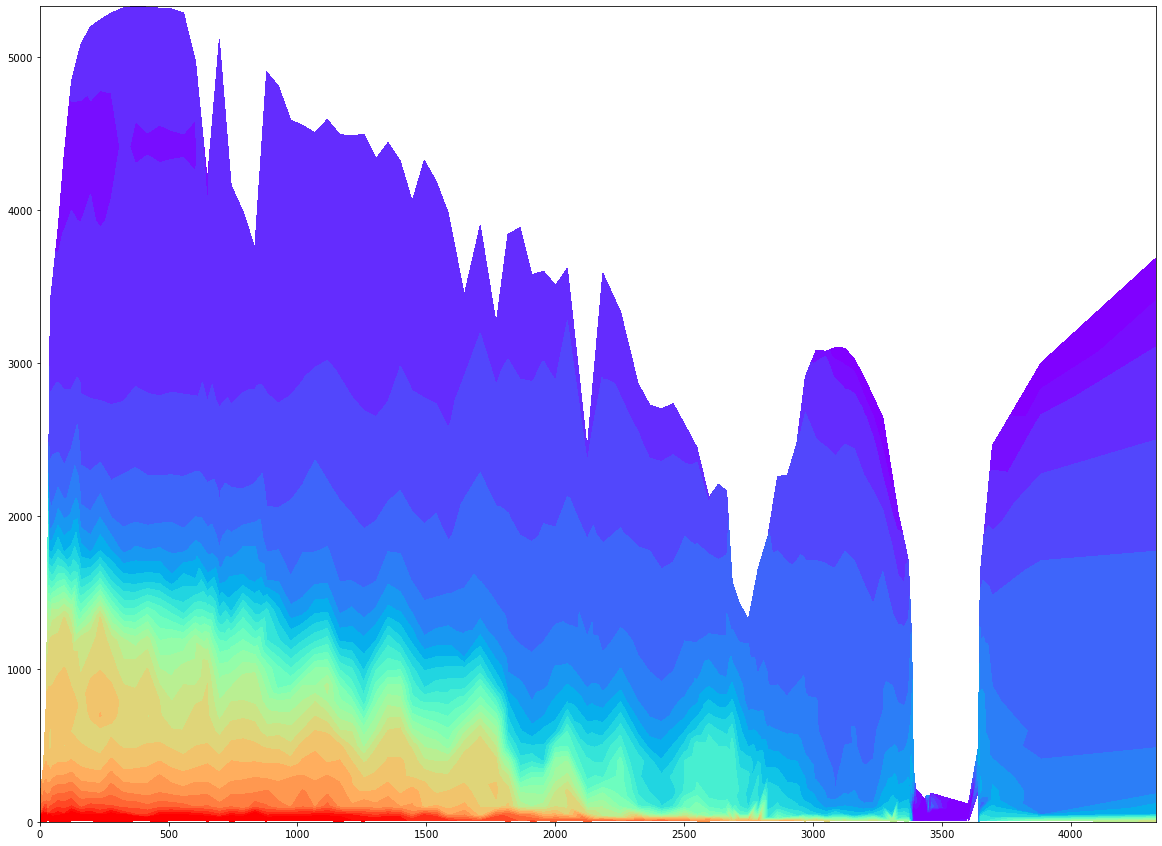

In [50]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,15))
ax = plt.subplot(111)
cmap=plt.get_cmap('rainbow')
pcolor=plt.contourf(yy,-1*depthOV,tempOV_mask,np.arange(2,16,0.5),cmap=cmap,extend='both')

In [41]:
depthOV.shape

(24, 103)

In [55]:
from netCDF4 import Dataset
outname="/scratch/cnt0024/hmg2840/albert7a/OVIDE/coord_section_OVIDE2012-2.nc"
print('output file is '+outname)
dsout=Dataset(outname,'w')

dsout.description = "This file contains the location of the OVIDE section points for the 2012 campaign"

record=dsout.createDimension('record',103)
depth=dsout.createDimension('depth',24)

lat = dsout.createVariable('latitude', 'f8', ('record'))
lat.standart_name="latitude"
lat.long_name = "Latitude of OVIDE section" 
lat.units = "degrees_north"

lon = dsout.createVariable('longitude', 'f8', ('record'))
lon.standart_name="longitude"
lon.long_name = "Longitude of OVIDE section" 
lon.units = "degrees_east"

depth = dsout.createVariable('depth_OVIDE', 'f8', ('depth','record'),fill_value=0.)
depth.units = "m" 
depth.valid_min = 0.
depth.valid_max = 8000.
depth.long_name = "Depth" 

temp = dsout.createVariable('temp_OVIDE', 'f8', ('depth','record'),fill_value=0.)
temp.units = "degC" 
temp.valid_min = -10.
temp.valid_max = 40.
temp.long_name = "Temperature section along the OVIDE campaign" 

lat[:]=latOV
lon[:]=lonOV
depth[:]=depthOV
temp[:]=tempOV
dsout.close()


output file is /scratch/cnt0024/hmg2840/albert7a/OVIDE/coord_section_OVIDE2012-2.nc
